<a href="https://colab.research.google.com/github/pilatova/prot-viz-data/blob/main/ratios_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

dist = pd.read_csv(
    "https://raw.githubusercontent.com/pilatova/prot-viz-data/main/dist3.tsv",
    sep='\t',           # Tab separator for TSV files
    header=0,           # Use the first row as headers
    index_col=0         # Set the first column as the index
)

goslim = pd.read_csv(
    "https://raw.githubusercontent.com/pilatova/prot-viz-data/main/goslim.tsv",
    sep='\t',           # Tab separator for TSV files
    header=0,           # Use the first row as headers
    index_col=0         # Set the first column as the index
)

goslim_names = pd.read_csv(
    "https://raw.githubusercontent.com/pilatova/prot-viz-data/main/goslim-names.tsv",
    sep='\t',           # Tab separator for TSV files
    header=0,           # Use the first row as headers
    index_col=0         # Set the first column as the index
)

Vypočítame pomery vzdialeností pre všetky rôzne dvojice dvojíc organizmov.

In [2]:
ratios = pd.DataFrame({f'{col1}/{dist.columns[j]}' : dist[col1] / dist[dist.columns[j]]
    for i, col1 in enumerate(dist.columns)
    for j, col2 in enumerate(dist.columns)
    if i != j
})
ratios.describe()

,human-baboon/human-cow,human-baboon/human-dog,human-baboon/human-mouse,human-baboon/human-opossum,human-baboon/baboon-cow,human-baboon/baboon-dog,human-baboon/baboon-mouse,human-baboon/baboon-opossum,human-baboon/cow-dog,human-baboon/cow-mouse,...,mouse-opossum/human-opossum,mouse-opossum/baboon-cow,mouse-opossum/baboon-dog,mouse-opossum/baboon-mouse,mouse-opossum/baboon-opossum,mouse-opossum/cow-dog,mouse-opossum/cow-mouse,mouse-opossum/cow-opossum,mouse-opossum/dog-mouse,mouse-opossum/dog-opossum
count,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,...,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000
mean,44.825784,39.683398,29.410485,22.845037,2.348696,3.418015,1.352583,0.996684,28.943352,27.664055,...,3.173710,91.678226,112.422640,39.733554,3.134790,116.960078,36.175261,3.435417,41.006140,3.524157
std,1038.472744,968.831404,861.860882,838.126141,149.306194,102.286855,47.148350,58.053530,704.196601,905.186020,...,74.473355,1138.488653,1334.332561,586.475418,74.044869,1310.666791,568.424960,77.484221,615.011948,75.233366
min,0.000030,0.000014,0.000015,0.000010,0.000025,0.000012,0.000015,0.000010,0.000008,0.000015,...,0.000567,0.000018,0.000015,0.000018,0.000018,0.000015,0.000064,0.000064,0.000015,0.000013
25%,0.141005,0.154545,0.108848,0.053514,0.140339,0.151399,0.109102,0.053409,0.140268,0.090810,...,1.025613,1.814668,1.917204,1.578728,1.000039,1.983581,1.434005,0.991679,1.485614,1.000000
50%,0.213733,0.233948,0.166322,0.091226,0.213009,0.230770,0.166001,0.090354,0.227995,0.143860,...,1.107541,2.519143,2.706851,1.951894,1.093810,2.803248,1.765036,1.069725,1.836054,1.092643
75%,0.326088,0.358627,0.254016,0.142660,0.319782,0.346004,0.252356,0.140828,0.372007,0.229403,...,1.210950,3.563223,3.956720,2.557387,1.199514,4.137774,2.315749,1.175532,2.421552,1.202554
max,54819.600000,59245.000000,54819.600000,54819.600000,16688.100000,9417.500000,4041.800000,4952.200000,38650.900000,54819.600000,...,6246.900000,55246.500000,55246.500000,36307.900000,4952.200000,55246.500000,35736.700000,6246.900000,35736.700000,6246.900000


In [3]:
def find_extreme_ratio_proteins(species, top_n=300):
  """Funkcia pomocou tabulky ratios najde proteiny, ktore pre dany druh (species)
  maju najvacsi pomer vzdialenosti od ostatnych druhov voci ostatnym parom druhov
  """
  relevant_columns = [name for name in ratios.columns
    if species in name.split('/')[0] and species not in name.split('/')[1]]
  common_extreme_proteins = None
  for col in relevant_columns:
    sorted_ratios = ratios[col].sort_values(ascending=False)
    extreme_ratios = sorted_ratios[:top_n].index
    if common_extreme_proteins is not None:
      common_extreme_proteins = common_extreme_proteins.intersection(set(extreme_ratios))
    else:
      common_extreme_proteins = set(extreme_ratios)
  return common_extreme_proteins


def count_functions(highest_ratio_proteins, cutoff=1):
  """Funkcia spocita ake funkcie maju proteiny v highest_ratio_proteins a pripadne
  odfiltruje podla pocetnosti > cutoff
  """
  valid_indices = [x for x in highest_ratio_proteins if x in goslim.index]
  highest_ratio_proteins_function_ids = goslim.loc[valid_indices].reset_index()
  function_id_frequency = highest_ratio_proteins_function_ids.groupby('go_id')['go_id'].count().sort_values(ascending=False)
  function_id_frequency.name = 'count'
  function_id_frequency = function_id_frequency.to_frame().query('count > @cutoff')
  named_function_frequencies = function_id_frequency.join(goslim_names)
  return named_function_frequencies


In [4]:
top_n_species_proteins = {}
top_n_species_proteins_counts = {}
for top_n in range(100, 1001, 100):
  top_n_species_proteins[top_n] = {}
  top_n_species_proteins_counts[top_n] = {}
  for species in ('human', 'baboon', 'cow', 'dog', 'mouse', 'opossum'):
    top_n_species_proteins[top_n][species] = find_extreme_ratio_proteins(species, top_n)
    top_n_species_proteins_counts[top_n][species] = len(top_n_species_proteins[top_n][species])


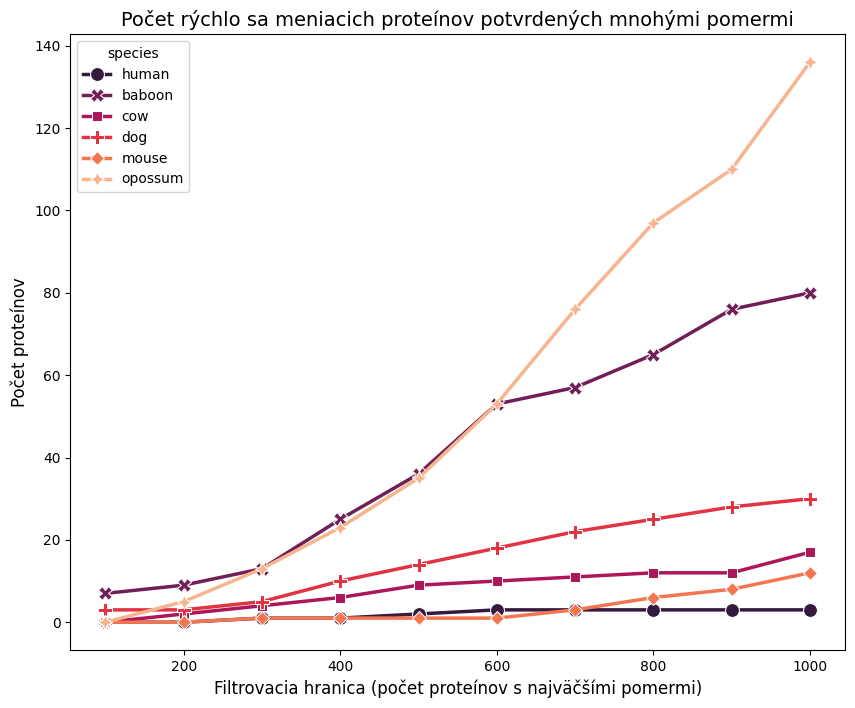

In [18]:
df_counts = pd.DataFrame(top_n_species_proteins_counts)
df_counts_long = df_counts.reset_index().melt(id_vars='index', var_name='top_n',
                                              value_name='count')
df_counts_long.rename(columns={'index': 'species'}, inplace=True)

palette = sns.color_palette("rocket")
plt.figure(figsize=(10, 8))
sns.lineplot(data=df_counts_long, x='top_n', y='count', hue='species',
             style='species', palette=palette, linewidth=2.5,
             markersize=10, markers=True, dashes=False)
plt.title("Počet rýchlo sa meniacich proteínov potvrdených mnohými pomermi", fontsize=14)
plt.xlabel("Filtrovacia hranica (počet proteínov s najväčšími pomermi)", fontsize=12)
plt.ylabel("Počet proteínov", fontsize=12)
plt.show()

Z grafu je vidieť, že vačica a pavián majú najväčší počet týchto veľmi rýchlo sa meniacich proteínov, čo možno naznačuje, že sú to druhy, u ktorých životné podmienky podmienili veľa rôznych zmien od čias oddelenia od spoločného predka.

Ďalej sa pozrieme na najčastejšie funkcie ktoré tieto proteíny majú a porovnáme to s najčastejšími funkciami celkovo u všetkých skúmaných proteínov.

In [52]:
def compute_function_frequency_from_proteins(proteins):
  """Funkcia pomocou údajov z goslim a goslim_names pre dané proteíny (proteins)
  zistí frekvencie funkcií týchto proteínov
  """
  proteins = pd.Series(proteins, name='protein_id')
  proteins_with_go_id = goslim.merge(proteins, on='protein_id', how='inner')
  function_occurrences = proteins_with_go_id.groupby('go_id') \
    .agg(occurrence=('protein_id', 'count')) \
    .sort_values('occurrence', ascending=False)
  function_occurrences['frequency'] = function_occurrences['occurrence'] / len(proteins) * 100
  function_occurrences = function_occurrences.merge(goslim_names, on='go_id', how='left')
  function_occurrences.rename(columns={'name': 'function'}, inplace=True)
  return function_occurrences

<Axes: xlabel='frequency'>

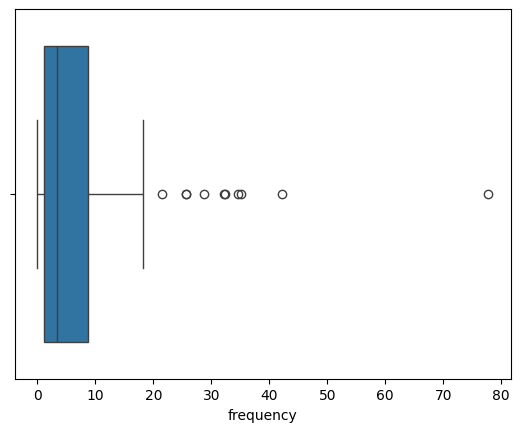

In [59]:
standard_frequency = compute_function_frequency_from_proteins(list(dist.index))
sns.boxplot(x=standard_frequency['frequency'])

Zameriame sa na outliery, teda funkcie s frekvenciou $\geq 20\%$.

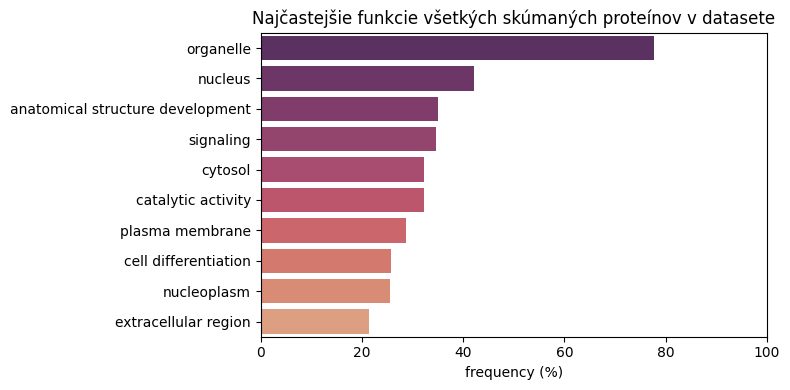

In [99]:
most_frequent = standard_frequency.query('frequency >= 20')
palette = sns.color_palette("flare_r", n_colors=len(most_frequent))
plt.figure(figsize=(8, 4))
sns.barplot(most_frequent, y='function', x='frequency',
            orient='h', hue='function', palette=palette)
plt.title('Najčastejšie funkcie všetkých skúmaných proteínov v datasete')
plt.xlabel('frequency (%)')
plt.ylabel('')
plt.xlim(0, 100)
plt.tight_layout()

<Axes: xlabel='species', ylabel='frequency'>

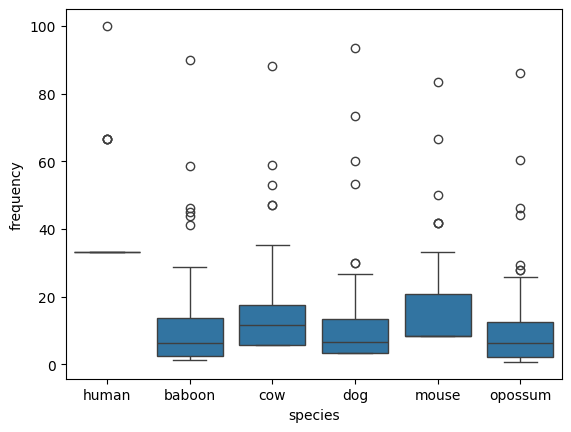

In [87]:
selected_n = 1000
species_list = []
all_data = []
for species, proteins in top_n_species_proteins[selected_n].items():
  frequencies = compute_function_frequency_from_proteins(list(proteins))
  frequencies['species'] = species
  all_data.append(frequencies)
  species_list.append(species)

frequencies = pd.concat(all_data)
sns.boxplot(data=frequencies, x='species', y='frequency')

Znova sa zameriame na outliery, s frekvenciou $\geq 30\%$.

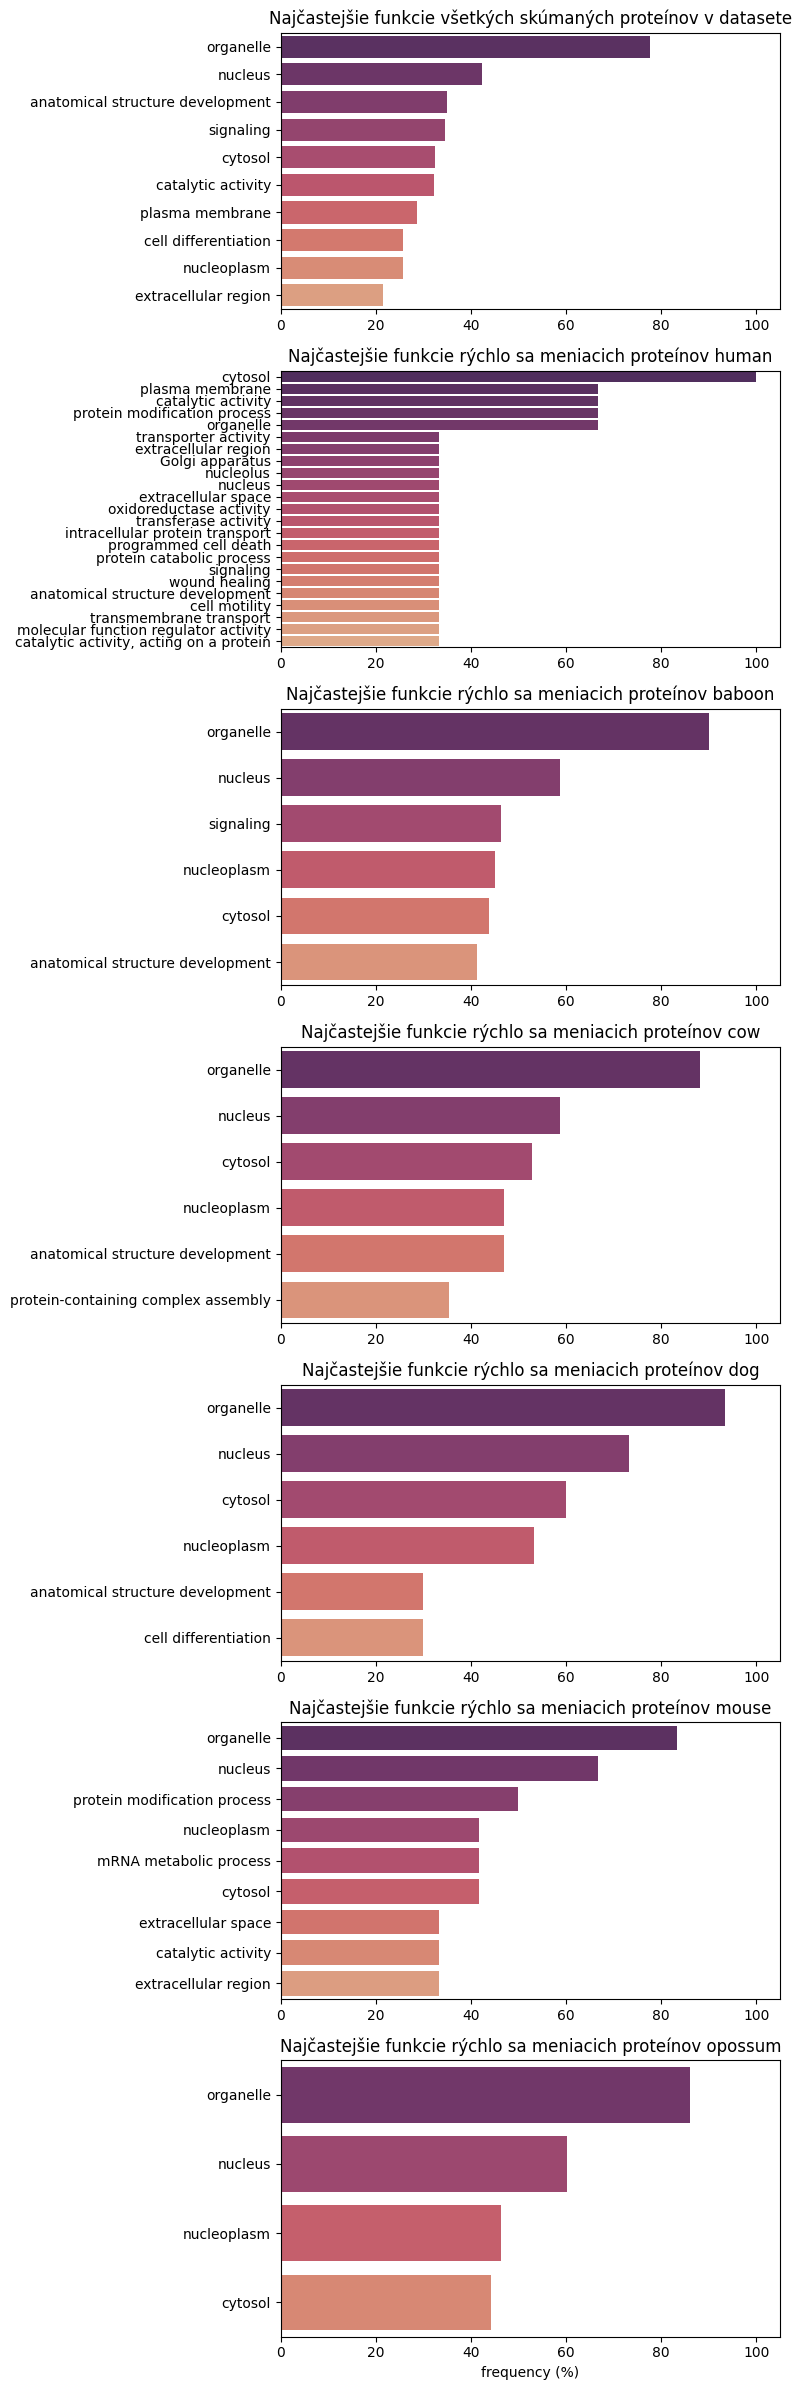

In [101]:
fig, axes = plt.subplots(len(species_list) + 1, 1, figsize=(8, 4 * len(species_list)),
                         sharex=True)
most_frequent = standard_frequency.query('frequency >= 20')
palette = sns.color_palette("flare_r", n_colors=len(most_frequent))
sns.barplot(most_frequent, y='function', x='frequency',
            orient='h', hue='function', palette=palette, ax=axes[0])
axes[0].set_title('Najčastejšie funkcie všetkých skúmaných proteínov v datasete')
axes[0].set_xlabel('frequency (%)')
axes[0].set_ylabel('')
axes[0].tick_params(labelbottom=True)

for i, (species, ax) in enumerate(zip(species_list, axes[1:])):
  most_frequent = all_data[i].query('frequency >= 30')
  palette = sns.color_palette("flare_r", n_colors=len(most_frequent))
  sns.barplot(most_frequent, y='function', x='frequency',
              orient='h', hue='function', palette=palette, ax=ax)
  ax.set_title(f'Najčastejšie funkcie rýchlo sa meniacich proteínov {species}')
  ax.set_xlabel('frequency (%)')
  ax.tick_params(labelbottom=True)
  ax.set_ylabel('')

plt.tight_layout()

Okrem človeka, ktorý mal medzi najrýchlejšie sa meniacimi proteínmi iba 3 proteíny sú grafy pre všetky ostatné druhy veľmi podobné grafu pre frekvencie funkcií všetkých skúmaných proteínov v datasete.
Niektoré zmeny sú:

- Funkcie organelle, nucleus majú vyššie frekvencie u rýchlo sa meniacich proteínov

- Pavián má omnoho väčšiu frekvenciu signalling (34 vs 46), cytosol (32 vs 43), nucleoplasm (26 vs 45), chýba mu catalytic activity

- Krava má omnoho väčšiu frekvenciu anatomical structure development (35 vs 47), cytosol (32 vs 53), nucleoplasm (26 vs 47), chýba tam signalling, catalytic activity

- Krava má navyše 35% frekvenciu protein-containing complex assembly

- Pes má omnoho väčšiu frekvenciu cytosol (32 vs 60), nucleoplasm (26 vs 53), chýba tam signalling, catalytic activity

- Myš má omnoho väčšiu frekvenciu nucleoplasm (26 vs 42), chýba tam anatomical structure development, signalling

- Myš má navyše 50% protein modification process, 42%	mRNA metabolic process, 33%	extracellular space

- Vačica má omnoho väčšiu frekvenciu cytosol (32 vs 44), nucleoplasm (26 vs 46), chýba tam anatomical structure development, signalling, catalytic activity


In [131]:
my_query = standard_frequency.query('frequency >= 20')
display(my_query)
function_filter = my_query.index
for x in [all_data[5]]:
  my_query = x.query('frequency >= 30')
  #valid_filter = [filt for filt in function_filter if filt in my_query.index]
  display(my_query)

,occurrence,frequency,function
go_id,,,
GO:0043226,10125,77.764977,organelle
GO:0005634,5500,42.242704,nucleus
GO:0048856,4563,35.046083,anatomical structure development
GO:0023052,4501,34.569892,signaling
GO:0005829,4212,32.350230,cytosol
GO:0003824,4191,32.188940,catalytic activity
GO:0005886,3740,28.725038,plasma membrane
GO:0030154,3346,25.698925,cell differentiation
GO:0005654,3337,25.629800,nucleoplasm


,occurrence,frequency,function,species
go_id,,,,
GO:0043226,117,86.029412,organelle,opossum
GO:0005634,82,60.294118,nucleus,opossum
GO:0005654,63,46.323529,nucleoplasm,opossum
GO:0005829,60,44.117647,cytosol,opossum
